In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
import pandas as pd
import copy

from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset, ConcatDataset
from rdkit import Chem
from conf_ensemble_dataset_in_memory import ConfEnsembleDataset
from rdkit.Chem import AllChem #needed for rdForceFieldHelpers
from collections import defaultdict
from litschnet import LitSchNet
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from rmsd_predictor_evaluator import RMSDPredictorEvaluator
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

# Data preparation

In [3]:
data_dir = 'data/'

In [4]:
# run once to preprocess datasets and generate chunks
# dataset = ConfEnsembleDataset()
# dataset = ConfEnsembleDataset(dataset='platinum') # 16G

In [5]:
platinum_chunks = [filename for filename in os.listdir(os.path.join(data_dir, 'processed')) if filename.startswith('platinum')]
platinum_n_chunks = len(platinum_chunks)

In [6]:
platinum_datasets = []
for chunk_number in tqdm(range(platinum_n_chunks)) :
    dataset = ConfEnsembleDataset(dataset='platinum', loaded_chunk=chunk_number)
    platinum_datasets.append(dataset)
platinum_dataset = ConcatDataset(platinum_datasets)

100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.05s/it]


In [7]:
pdbbind_chunks = [filename for filename in os.listdir(os.path.join(data_dir, 'processed')) if filename.startswith('pdbbind')]
pdbbind_n_chunks = len(pdbbind_chunks)

In [8]:
splits = ['random', 'scaffold']

In [9]:
for split in splits :

    for iteration in range(5) :

        with open(os.path.join(data_dir, f'{split}_splits', f'train_smiles_{split}_split_{iteration}.txt'), 'r') as f :
            train_smiles = f.readlines()
            train_smiles = [smiles.strip() for smiles in train_smiles]

        with open(os.path.join(data_dir, f'{split}_splits', f'val_smiles_{split}_split_{iteration}.txt'), 'r') as f :
            val_smiles = f.readlines()
            val_smiles = [smiles.strip() for smiles in val_smiles]

        with open(os.path.join(data_dir, f'{split}_splits', f'test_smiles_{split}_split_{iteration}.txt'), 'r') as f :
            test_smiles = f.readlines()
            test_smiles = [smiles.strip() for smiles in test_smiles]

        train_datasets = []
        val_datasets = []
        test_datasets = []

        for chunk_number in tqdm(range(pdbbind_n_chunks)) :

            dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                          smiles_list=train_smiles)
            train_datasets.append(dataset)

            dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                          smiles_list=val_smiles)
            val_datasets.append(dataset)

            dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                          smiles_list=test_smiles)
            test_datasets.append(dataset)

        train_dataset = ConcatDataset(train_datasets)
        val_dataset = ConcatDataset(val_datasets)
        test_dataset = ConcatDataset(test_datasets)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

        experiment_name = f'{split}_split_{iteration}_new'
        if experiment_name in os.listdir('lightning_logs') :
            checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
            checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
            litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
        else :
            litschnet = LitSchNet()
            logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
            trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
            trainer.fit(litschnet, train_loader, val_loader)
            trainer.test(litschnet, test_loader)

100%|█████████████████████████████████████████████| 3/3 [03:40<00:00, 73.46s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:57: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.42427268624305725}
--------------------------------------------------------------------------------


100%|█████████████████████████████████████████████| 3/3 [03:44<00:00, 74.71s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.477496862411499}
--------------------------------------------------------------------------------


100%|█████████████████████████████████████████████| 3/3 [03:42<00:00, 74.01s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.44268909096717834}
--------------------------------------------------------------------------------


100%|█████████████████████████████████████████████| 3/3 [03:46<00:00, 75.44s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3940860331058502}
--------------------------------------------------------------------------------


100%|█████████████████████████████████████████████| 3/3 [03:45<00:00, 75.10s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.37757402658462524}
--------------------------------------------------------------------------------


100%|█████████████████████████████████████████████| 3/3 [03:44<00:00, 74.90s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.44808804988861084}
--------------------------------------------------------------------------------


100%|█████████████████████████████████████████████| 3/3 [03:44<00:00, 74.90s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.45257827639579773}
--------------------------------------------------------------------------------


100%|█████████████████████████████████████████████| 3/3 [03:49<00:00, 76.62s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/benoit/bioactive_conformation_predictor/litschnet.py:44: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred.squeeze(), target)
  0%|                                                     | 0/3 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.46167871356010437}
--------------------------------------------------------------------------------


100%|█████████████████████████████████████████████| 3/3 [03:44<00:00, 74.68s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4042089283466339}
--------------------------------------------------------------------------------


100%|█████████████████████████████████████████████| 3/3 [03:46<00:00, 75.64s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4653269946575165}
--------------------------------------------------------------------------------


100%|█████████████████████████████████████████████| 3/3 [03:38<00:00, 72.98s/it]


Grouping data by smiles


  0%|                                                  | 0/1085 [00:00<?, ?it/s]

Starting evaluation


100%|███████████████████████████████████████| 1085/1085 [00:21<00:00, 51.61it/s]


Grouping data by smiles


  0%|                                          | 5/4548 [00:00<01:46, 42.69it/s]

Starting evaluation


100%|█████████████████████████████████████████████| 3/3 [03:45<00:00, 75.07s/it]


Grouping data by smiles


  0%|▏                                         | 5/1085 [00:00<00:26, 41.48it/s]

Starting evaluation


100%|███████████████████████████████████████| 1085/1085 [00:21<00:00, 51.00it/s]


Grouping data by smiles


  0%|                                          | 2/4548 [00:00<04:09, 18.24it/s]

Starting evaluation


100%|█████████████████████████████████████████████| 3/3 [03:47<00:00, 75.85s/it]


Grouping data by smiles


  1%|▍                                        | 10/1089 [00:00<00:13, 82.39it/s]

Starting evaluation


100%|███████████████████████████████████████| 1089/1089 [00:21<00:00, 51.16it/s]


Grouping data by smiles


  0%|                                          | 2/4548 [00:00<04:31, 16.74it/s]

Starting evaluation


100%|█████████████████████████████████████████████| 3/3 [03:48<00:00, 76.29s/it]


Grouping data by smiles


  0%|▏                                         | 4/1088 [00:00<00:29, 37.13it/s]

Starting evaluation


100%|███████████████████████████████████████| 1088/1088 [00:21<00:00, 50.96it/s]


Grouping data by smiles


  0%|                                          | 2/4548 [00:00<04:11, 18.06it/s]

Starting evaluation


100%|█████████████████████████████████████████████| 3/3 [03:43<00:00, 74.53s/it]


Grouping data by smiles


  1%|▏                                         | 6/1088 [00:00<00:18, 57.96it/s]

Starting evaluation


100%|███████████████████████████████████████| 1088/1088 [00:21<00:00, 51.21it/s]


Grouping data by smiles


  0%|                                          | 2/4548 [00:00<03:51, 19.63it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [01:25<00:00, 53.36it/s]


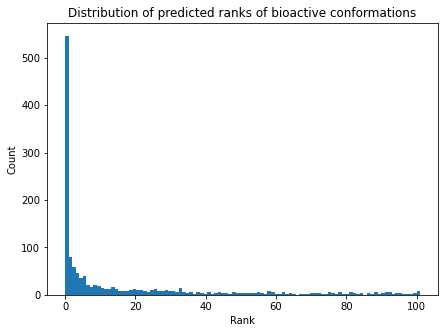

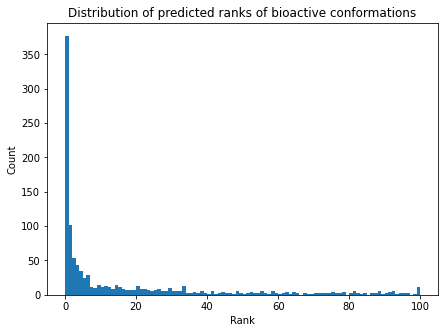

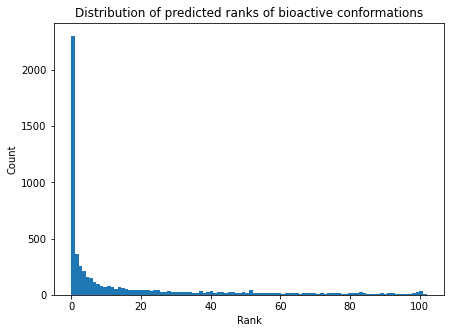

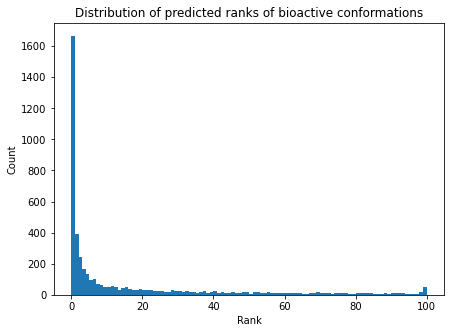

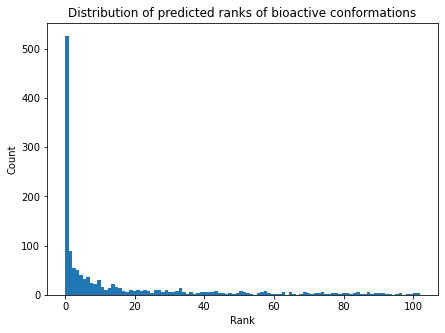

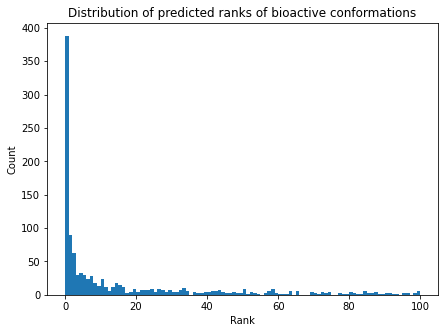

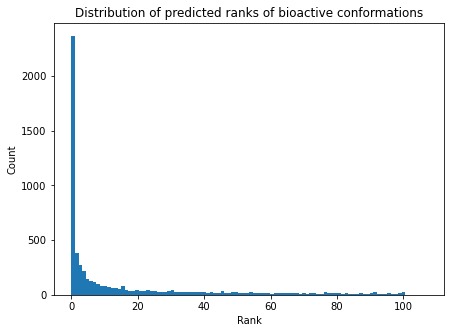

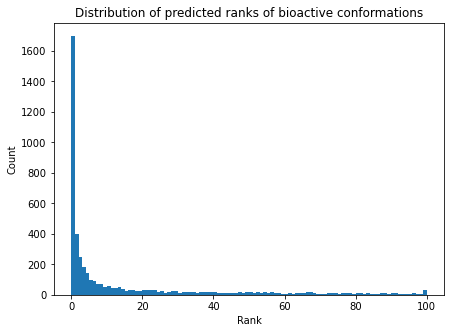

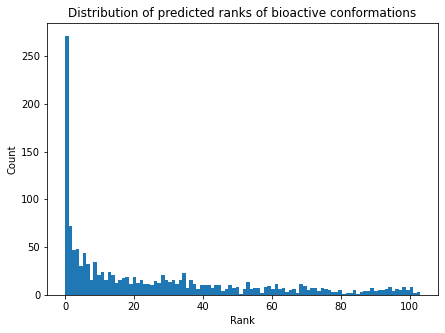

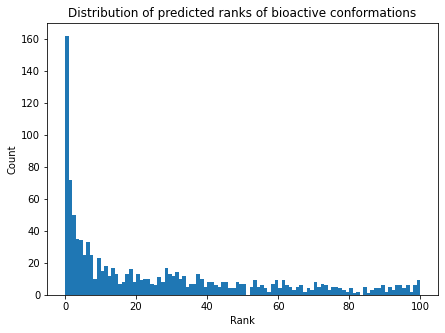

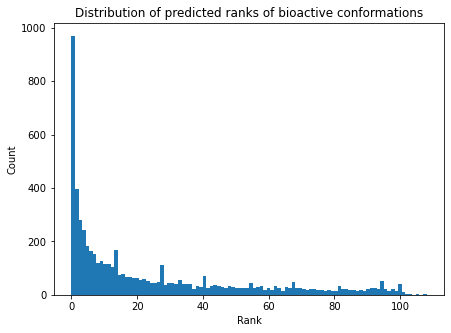

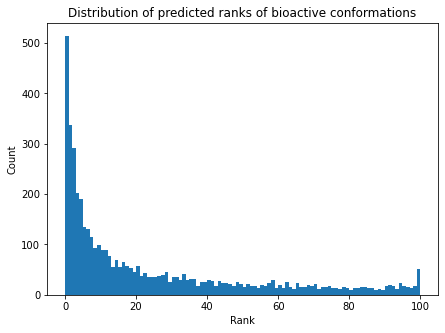

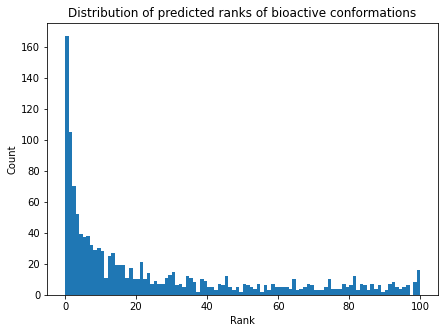

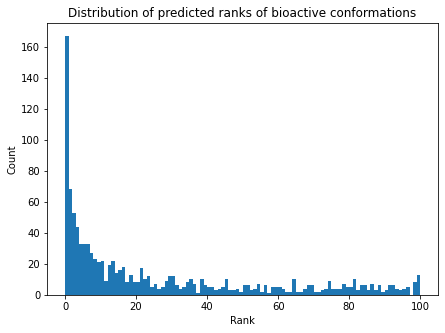

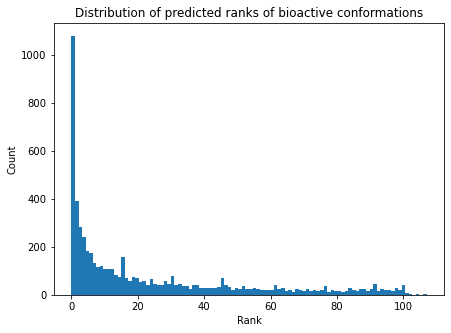

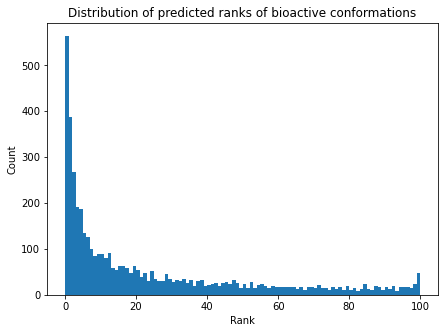

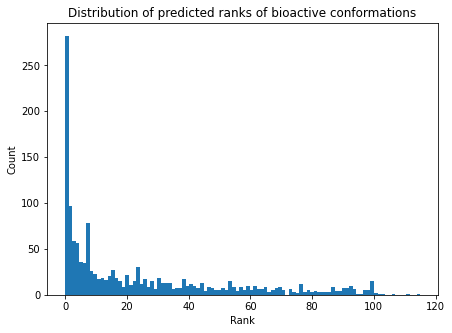

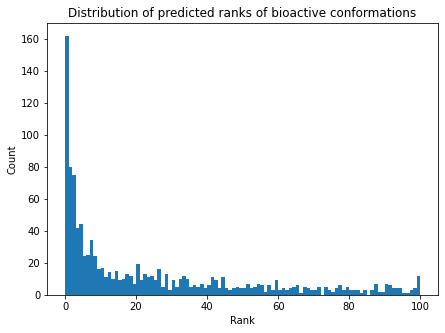

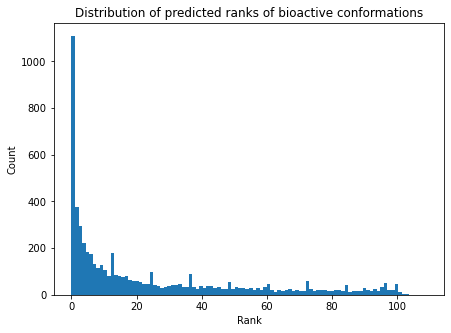

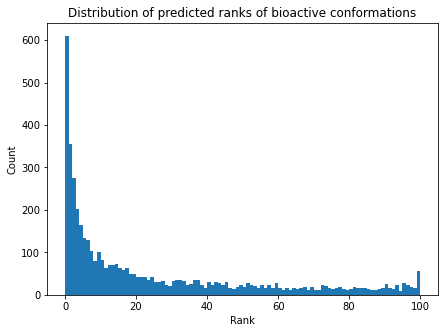

In [9]:
for iteration in range(5) :
    with open(os.path.join(data_dir, 'random_splits', f'train_smiles_random_split_{iteration}.txt'), 'r') as f :
        train_smiles = f.readlines()
        train_smiles = [smiles.strip() for smiles in train_smiles]
    
    with open(os.path.join(data_dir, 'random_splits', f'val_smiles_random_split_{iteration}.txt'), 'r') as f :
        val_smiles = f.readlines()
        val_smiles = [smiles.strip() for smiles in val_smiles]

    with open(os.path.join(data_dir, 'random_splits', f'test_smiles_random_split_{iteration}.txt'), 'r') as f :
        test_smiles = f.readlines()
        test_smiles = [smiles.strip() for smiles in test_smiles]
        
    train_datasets = []
    val_datasets = []
    test_datasets = []

    for chunk_number in tqdm(range(pdbbind_n_chunks)) :

        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=train_smiles)
        train_datasets.append(dataset)

        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=val_smiles)
        val_datasets.append(dataset)

        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=test_smiles)
        test_datasets.append(dataset)
        
    train_dataset = ConcatDataset(train_datasets)
    val_dataset = ConcatDataset(val_datasets)
    test_dataset = ConcatDataset(test_datasets)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    experiment_name = f'random_split_{iteration}_new'
    if experiment_name in os.listdir('lightning_logs') :
        checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
        checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
        litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        litschnet = LitSchNet()
        logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
        trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
        trainer.fit(litschnet, train_loader, val_loader)
        trainer.test(litschnet, test_loader)
    
    evaluation_name = experiment_name + '_pdbbind'
    evaluator = RMSDPredictorEvaluator(model=litschnet, evaluation_name=evaluation_name)
    evaluator.evaluate(test_dataset)

    evaluation_name = experiment_name + '_platinum'
    evaluator = RMSDPredictorEvaluator(model=litschnet, evaluation_name=evaluation_name)
    evaluator.evaluate(platinum_dataset)